In [1]:
from __future__ import division
import gym
from gym.envs.registration import register
import numpy as np
import random, math, time
import copy
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [2]:
register(
    id          ='FrozenLakeNotSlippery-v0',
    entry_point ='gym.envs.toy_text:FrozenLakeEnv',
    kwargs      ={'map_name' : '8x8', 'is_slippery': False},
)

def running_mean(x, N=20):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [44]:
class Agent:
    def __init__(self, env):
        self.stateCnt      = env.observation_space.n
        self.actionCnt     = env.action_space.n         # left:0; down:1; right:2; up:3
        self.learning_rate = 1
        self.gamma         = 0.9
        self.epsilon       = 0.5
        self.Q             = self._initialiseModel()

    def _initialiseModel(self):
        qtable= np.zeros((self.stateCnt, self.actionCnt))
        return qtable

    def predict_value(self, s):
        action= self.Q[s, :]
        return action

    def update_value_Qlearning(self, s,a,r,s_next, goalNotReached):
        if(goalNotReached):
            predict= self.Q[s, a]
            target= r+ self.gamma*np.max(self.Q[s_next, :])
            self.Q[s, a]= self.Q[s, a]+ self.learning_rate*(target- predict)
        else:
            self.Q[s, a]= self.Q[s, a]+ self.learning_rate*(r - self.Q[s, a])

    def update_value_SARSA(self, s,a,r,s_next, a_next, goalNotReached):
        if(goalNotReached):
            predict= self.Q[s, a]
            target= r+ self.gamma*self.Q[s_next, a_next]
            self.Q[s, a]= self.Q[s, a]+ self.learning_rate*(target- predict)
        else:
            self.Q[s, a]= self.Q[s, a]+ self.learning_rate*(r - self.Q[s, a])

    def choose_action(self, s):
        if(np.random.uniform(0, 1) < self.epsilon):
            best_action= env.action_space.sample()
        else:
            best_action= np.argmax(self.Q[s, :]+ np.random.randn(1, 4))
        return best_action

    def updateEpsilon(self, episodeCounter):
        #self.epsilon= 0.01+ (1- 0.01)*np.exp(-0.005*episodeCounter)
        self.epsilon-= 0.0005
        return


In [45]:
class World:
    def __init__(self, env):
        self.env = env
        print('Environment has %d states and %d actions.' % (self.env.observation_space.n, self.env.action_space.n))
        self.stateCnt           = self.env.observation_space.n
        self.actionCnt          = self.env.action_space.n
        self.maxStepsPerEpisode = 100
        self.q_Sinit_progress   = np.array([[0, 0, 0, 0]])   # ex: np.array([[0,0,0,0]])

    def run_episode_qlearning(self):
        s               = self.env.reset() # "reset" environment to start state
        r_total         = 0
        episodeStepsCnt = 0
        success         = False
        for i in range(self.maxStepsPerEpisode):
            # self.env.step(a): "step" will execute action "a" at the current agent state and move the agent to the next state.
            # step will return the next state, the reward, a boolean indicating if a terminal state is reached,
            #and some diagnostic information useful for debugging.
            
            # self.env.render(): "render" will print the current environment state.
            #self.env.render()
            action= agent.choose_action(s)
            s_next, r, done, info= self.env.step(action)
            agent.update_value_Qlearning(s, action, r, s_next, not done)
            r_total+= r
            s= s_next
            #print(r_total)
            if(done):   #we are dead, finish episode
                #self.env.render()
                #print("No of steps :", i+1)
                episodeStepsCnt= i+1
                break
            # self.q_Sinit_progress = np.append( ): use q_Sinit_progress for monitoring the q value progress 
            #throughout training episodes for all available actions at the initial state.
        self.q_Sinit_progress= np.append(self.q_Sinit_progress, [agent.Q[s, :]], axis=0)
        return r_total, episodeStepsCnt

    def run_episode_sarsa(self):
        s               = self.env.reset() # "reset" environment to start state
        r_total         = 0
        episodeStepsCnt = 0
        success         = False
        action= agent.choose_action(s)
        for i in range(self.maxStepsPerEpisode):
            # self.env.step(a): "step" will execute action "a" at the current agent state and move the agent to the next state.
            # step will return the next state, the reward, a boolean indicating if a terminal state is reached, 
            #and some diagnostic information useful for debugging.
            
            # self.env.render(): "render" will print the current environment state.
            #self.env.render
            s_next, r, done, info= self.env.step(action)
            action2= agent.choose_action(s_next)
            agent.update_value_SARSA(s, action, r, s_next, action2, not done)
            r_total+= r
            s= s_next
            action= action2
            if(done):
                #self.env.render()
                #print("No of steps :", i+1)
                episodeStepsCnt= i+1
                break
            # self.q_Sinit_progress = np.append( ): use q_Sinit_progress for monitoring the q value progress 
            #throughout training episodes for all available actions at the initial state
        self.q_Sinit_progress= np.append(self.q_Sinit_progress, [agent.Q[s, :]], axis=0)
        return r_total, episodeStepsCnt

    def run_evaluation_episode(self):
        agent.epsilon = 0
        state= self.env.reset()
        step= 0
        success= False
        for step in range(self.maxStepsPerEpisode):
            self.env.render()
            action= np.argmax(agent.Q[state, :])
            new_state, reward, done, info= self.env.step(action)
            state= new_state
            if(reward == 1):
                success= True
                break    
        return success


Environment has 64 states and 4 actions.

   Episode: 0
0.0

   Episode: 1
0.0

   Episode: 2
0.0

   Episode: 3
0.0

   Episode: 4
0.0

   Episode: 5
0.0

   Episode: 6
0.0

   Episode: 7
0.0

   Episode: 8
0.0

   Episode: 9
0.0

   Episode: 10
0.0

   Episode: 11
0.0

   Episode: 12
0.0

   Episode: 13
0.0

   Episode: 14
0.0

   Episode: 15
0.0

   Episode: 16
0.0

   Episode: 17
0.0

   Episode: 18
0.0

   Episode: 19
0.0

   Episode: 20
0.0

   Episode: 21
0.0

   Episode: 22
0.0

   Episode: 23
0.0

   Episode: 24
0.0

   Episode: 25
0.0

   Episode: 26
0.0

   Episode: 27
0.0

   Episode: 28
0.0

   Episode: 29
0.0

   Episode: 30
0.0

   Episode: 31
0.0

   Episode: 32
0.0

   Episode: 33
0.0

   Episode: 34
0.0

   Episode: 35
0.0

   Episode: 36
0.0

   Episode: 37
0.0

   Episode: 38
0.0

   Episode: 39
0.0

   Episode: 40
0.0

   Episode: 41
0.0

   Episode: 42
0.0

   Episode: 43
0.0

   Episode: 44
0.0

   Episode: 45
0.0

   Episode: 46
0.0

   Episode: 47
0.0

   Episo

0.0

   Episode: 167
0.0

   Episode: 168
0.0

   Episode: 169
0.0

   Episode: 170
0.0

   Episode: 171
0.0

   Episode: 172
0.0

   Episode: 173
0.0

   Episode: 174
0.0

   Episode: 175
0.0

   Episode: 176
0.0

   Episode: 177
0.0

   Episode: 178
0.0

   Episode: 179
0.0

   Episode: 180
0.0

   Episode: 181
0.0

   Episode: 182
0.0

   Episode: 183
0.0

   Episode: 184
0.0

   Episode: 185
0.0

   Episode: 186
0.0

   Episode: 187
0.0

   Episode: 188
0.0

   Episode: 189
0.0

   Episode: 190
0.0

   Episode: 191
0.0

   Episode: 192
0.0

   Episode: 193
0.0

   Episode: 194
0.0

   Episode: 195
0.0

   Episode: 196
0.0

   Episode: 197
0.0

   Episode: 198
0.0

   Episode: 199
0.0

   Episode: 200
0.0

   Episode: 201
0.0

   Episode: 202
0.0

   Episode: 203
0.0

   Episode: 204
0.0

   Episode: 205
0.0

   Episode: 206
0.0

   Episode: 207
0.0

   Episode: 208
0.0

   Episode: 209
0.0

   Episode: 210
0.0

   Episode: 211
0.0

   Episode: 212
0.0

   Episode: 213
0.0

   Episo


   Episode: 518
0.0

   Episode: 519
0.0

   Episode: 520
0.0

   Episode: 521
0.0

   Episode: 522
0.0

   Episode: 523
0.0

   Episode: 524
0.0

   Episode: 525
0.0

   Episode: 526
0.0

   Episode: 527
0.0

   Episode: 528
0.0

   Episode: 529
0.0

   Episode: 530
0.0

   Episode: 531
0.0

   Episode: 532
0.0

   Episode: 533
0.0

   Episode: 534
0.0

   Episode: 535
0.0

   Episode: 536
0.0

   Episode: 537
0.0

   Episode: 538
0.0

   Episode: 539
0.0

   Episode: 540
0.0

   Episode: 541
0.0

   Episode: 542
0.0

   Episode: 543
0.0

   Episode: 544
0.0

   Episode: 545
0.0

   Episode: 546
0.0

   Episode: 547
0.0

   Episode: 548
0.0

   Episode: 549
0.0

   Episode: 550
0.0

   Episode: 551
0.0

   Episode: 552
0.0

   Episode: 553
0.0

   Episode: 554
0.0

   Episode: 555
0.0

   Episode: 556
0.0

   Episode: 557
0.0

   Episode: 558
0.0

   Episode: 559
0.0

   Episode: 560
0.0

   Episode: 561
0.0

   Episode: 562
0.0

   Episode: 563
0.0

   Episode: 564
0.0

   Episode: 

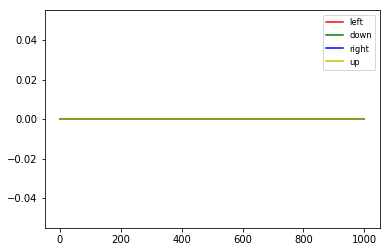

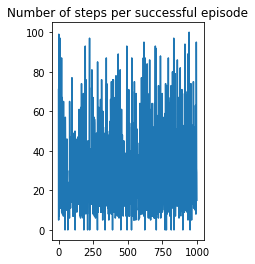

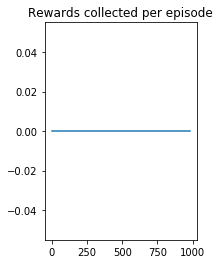

In [46]:
if __name__ == '__main__':
    env                      = gym.make('FrozenLakeNotSlippery-v0')
    world                    = World(env)
    agent                    = Agent(env) # This will creat an agent
    r_total_progress         = []
    episodeStepsCnt_progress = []
    nbOfTrainingEpisodes     = 1000
    for i in range(nbOfTrainingEpisodes):
        print ('\n========================\n   Episode: {}\n========================'.format(i))
        # run_episode_qlearning or run_episode_sarsa
        r_total_tmp, episodeStepsCnt_tmp= world.run_episode_qlearning()
        #r_total_tmp, episodeStepsCnt_tmp= world.run_episode_sarsa()
        agent.updateEpsilon(i)
        print(r_total_tmp)
        # append to r_total_progress and episodeStepsCnt_progress
        r_total_progress.append(r_total_tmp)
        episodeStepsCnt_progress.append(episodeStepsCnt_tmp)
    # run_evaluation_episode
    print(world.run_evaluation_episode())
    
    ### --- Plots --- ###
    # 1) plot world.q_Sinit_progress
    fig1 = plt.figure(1)
    plt.ion()
    plt.plot(world.q_Sinit_progress[:,0], label='left',  color = 'r')
    plt.plot(world.q_Sinit_progress[:,1], label='down',  color = 'g')
    plt.plot(world.q_Sinit_progress[:,2], label='right', color = 'b')
    plt.plot(world.q_Sinit_progress[:,3], label='up',    color = 'y')
    fontP = FontProperties()
    fontP.set_size('small')
    plt.legend(prop = fontP, loc=1)
    plt.pause(0.001)

    # 2) plot the evolution of the number of steps per successful episode throughout training. A successful episode is an episode where the agent reached the goal (i.e. not any terminal state)
    fig2 = plt.figure(2)
    plt1 = plt.subplot(1,2,1)
    plt1.set_title("Number of steps per successful episode")
    plt.ion()
    plt.plot(episodeStepsCnt_progress)
    plt.pause(0.0001)
    # 3) plot the evolution of the total collected rewards per episode throughout training. you can use the running_mean function to smooth the plot
    plt2 = plt.subplot(1,2,2)
    plt2.set_title("Rewards collected per episode")
    plt.ion()
    r_total_progress = running_mean(r_total_progress)
    plt.plot(r_total_progress)
    plt.pause(0.0001)
    ### --- ///// --- ###

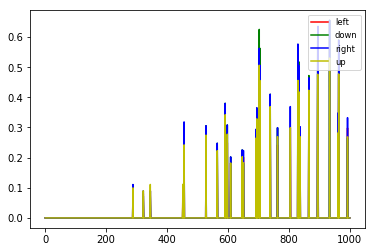

In [35]:
### --- Plots --- ###
# 1) plot world.q_Sinit_progress
fig1 = plt.figure(1)
plt.ion()
plt.plot(world.q_Sinit_progress[:,0], label='left',  color = 'r')
plt.plot(world.q_Sinit_progress[:,1], label='down',  color = 'g')
plt.plot(world.q_Sinit_progress[:,2], label='right', color = 'b')
plt.plot(world.q_Sinit_progress[:,3], label='up',    color = 'y')
fontP = FontProperties()
fontP.set_size('small')
plt.legend(prop = fontP, loc=1)
plt.pause(0.001)



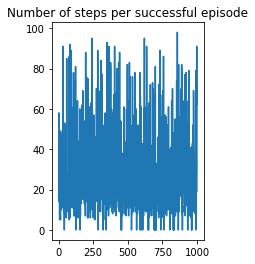

In [36]:
# 2) plot the evolution of the number of steps per successful episode throughout training. A successful episode is an episode where the agent reached the goal (i.e. not any terminal state)
fig2 = plt.figure(2)
plt1 = plt.subplot(1,2,1)
plt1.set_title("Number of steps per successful episode")
plt.ion()
plt.plot(episodeStepsCnt_progress)
plt.pause(0.0001)


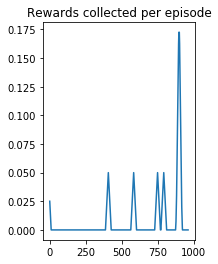

In [37]:
# 3) plot the evolution of the total collected rewards per episode throughout training. you can use the running_mean function to smooth the plot
plt2 = plt.subplot(1,2,2)
plt2.set_title("Rewards collected per episode")
plt.ion()
r_total_progress = running_mean(r_total_progress)
plt.plot(r_total_progress)
plt.pause(0.0001)
### --- ///// --- ###